In [80]:
from IPython.display import YouTubeVideo

import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import stats

from urllib import request
from io import StringIO

import plotly.graph_objects as go
sns.set_context('paper', font_scale=1.4)

# Number of cases, deaths and growth of Coronavirus

**Author:** Florencia Noriega

florencia.noriega@code.berlin

The purpose of this notebook is to explore the spread of COVID-19 from the official numbers reported to the World Health Organization. We download the data from https://ourworldindata.org/coronavirus and look at the number of confirmed cases, deaths and mortality rate by country. We also explore the growth of the number of cases of Coronavirus and fit a model assuming exponential growth.


## <a name="Outline"></a> Outline

* [Data](#Data)
* [Confirmed cases and deaths](#Cases)
* [Mortality rate](#CFR)
* [Growth of COVID-19](#Growth)
    * [Naive estimate of the growth rate R](#Naive)
    * [Estimate growth rate R](#R)
* [References](#References)

## <a name="Data"></a>  Download data

Load the data from https://ourworldindata.org/coronavirus [5]

In [81]:
time_series = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv',
                          parse_dates=[0], dtype={'location': 'category'})

print("{} rows \n{} countries\nfrom {} to {}".format(len(time_series), 
                                                         time_series['location'].nunique(),
                                                         time_series['date'].min(),
                                                         time_series['date'].max()))
time_series.sample(5)

9205 rows 
206 countries
from 2019-12-31 00:00:00 to 2020-04-06 00:00:00


,date,location,new_cases,new_deaths,total_cases,total_deaths
7152,2020-04-02,Rwanda,7,0,82,0
3109,2020-02-21,Georgia,0,0,0,0
2080,2020-01-22,Czech Republic,0,0,0,0
8585,2019-12-31,United Arab Emirates,0,0,0,0
5112,2020-01-13,Luxembourg,0,0,0,0


[Top](#Outline)

## <a name="Cases"></a>  Total cases and deaths by country


### Number of confirmed cases

* It is likely that there are more cases than the confirmed cases [1]
    * (+) many people barely have any symptoms
    * (+) even if you have severe symptoms you may not be tested to save resources for people who are most at risk
* (-) People recover, but they are not necessarily monitored. This means that there are some more registered cases that the real ones. As time increases this will become more. 

### Create dataframe with the number of confirmed cases and deaths

In [82]:
countries = pd.DataFrame(columns=['location', 'total_cases', 'total_deaths'])
countries['location'] = time_series['location'].unique()
countries['total_cases'] = time_series.groupby('location')['total_cases'].max().values
countries['total_deaths'] = time_series.groupby('location')['total_deaths'].max().values
countries.head()

,location,total_cases,total_deaths
0,Afghanistan,299,7
1,Albania,361,21
2,Algeria,1320,152
3,Andorra,501,18
4,Angola,14,2


### Total cases and deaths by country

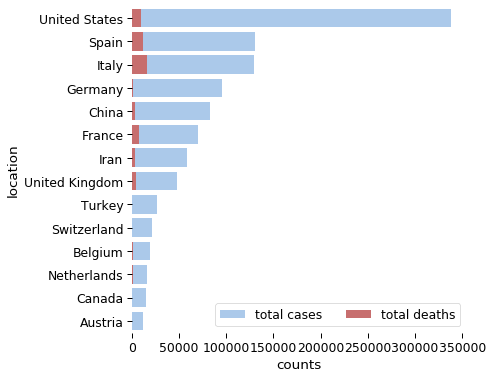

In [83]:
n = 15  # top n

## get locations sorted
sorted_cases = countries['total_cases'].sort_values(ascending=False)
sorted_cases_locs = countries.loc[sorted_cases.index]['location'].values

f, ax = plt.subplots(figsize = (6,6))

sns.set_color_codes('pastel')
sns.barplot(x='total_cases', y='location', data=countries, order=sorted_cases_locs[1:n],
           label='total cases', color='b')

sns.set_color_codes('muted')
sns.barplot(x='total_deaths', y='location', data=countries, order=sorted_cases_locs[1:n],
           label='total deaths', color='r')

ax.set_xlabel('counts')
ax.legend(ncol = 2, loc = 'lower right')
sns.despine(left = True, bottom = True)

In [84]:
df = countries.loc[countries['location'] != 'World'] # remove world

fig = go.Figure(data=go.Choropleth(
    locations = df['location'],
    locationmode = 'country names',
    z = np.log10(df['total_cases']),
    text = df['location'],
    colorscale = 'PuBu',
    autocolorscale = False,
    #reversescale=True,
    marker_line_color = 'darkgray',
    marker_line_width = 0.5,
    colorbar_tickprefix = '10^',
    colorbar_title = 'log(cases)',
))

fig.update_layout(
    title_text='Confirmed cases of COVID-19 on {}'.format(time_series['date'].max()),
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)


fig.show()

In [85]:
fig = go.Figure(data=go.Choropleth(
    locations = df['location'],
    locationmode = 'country names',
    z = np.log10(df['total_deaths']),
    text = df['location'],
    colorscale = 'Reds',
    autocolorscale=False,
    #reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix='10^',
    colorbar_title = 'log(cases)',
))

fig.update_layout(
    title_text='Deaths of COVID-19 on {}'.format(time_series['date'].max()),
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

[Top](#Outline)


## <a name="CFR"></a>  Mortality rate

Measured by the case fatality rate (CFR) [1]

$$
CFR = \frac{\mbox{number of deaths}}{\mbox{number of all cases}} \cdot 100
$$

* (-) As discussed above, we don't know the number of cases
* (+) We don't know the exact number of deaths due to Covid-19, likely there are more than the ones reported
* (-) Not clear if the patient is going to recover due to the time between the first symptoms and death
* (+-) Depends on the context; how old is the patient, available treatment

### Calculate the case fatality rate

In [107]:
countries['CFR'] = 100 * countries['total_deaths'] / countries['total_cases']
countries.head()

,location,total_cases,total_deaths,CFR
0,Afghanistan,299,7,2.341137
1,Albania,361,21,5.817175
2,Algeria,1320,152,11.515152
3,Andorra,501,18,3.592814
4,Angola,14,2,14.285714


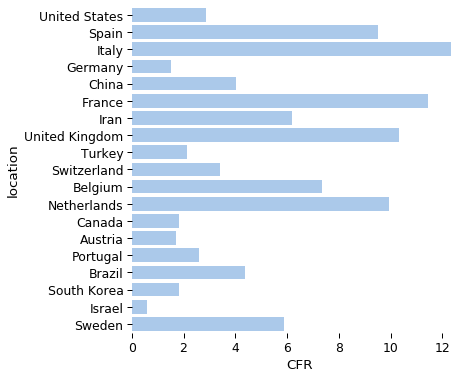

In [108]:
n = 20
f, ax = plt.subplots(figsize = (6,6))

sns.set_color_codes('pastel')

sns.barplot(x='CFR', y='location', data=countries, order=sorted_cases_locs[1:n],
           label='total cases', color='b')
sns.despine(left = True, bottom = True)


In [109]:
df = countries[countries['location'] != 'World']

fig = go.Figure(data=go.Choropleth(
    locations = df['location'],
    locationmode = 'country names',
    z = df['CFR'],
    text = df['location'],
    colorscale = 'Reds',
    autocolorscale=False,
    #reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    #colorbar_tickprefix='10^',
    colorbar_title = 'CFR',
))

fig.update_layout(
    title_text='Death rate of COVID-19 on {}'.format(time_series['date'].max()),
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)


fig.show()

[Top](#Outline)


## <a name="Growth"></a>  Growth of Coronavirus

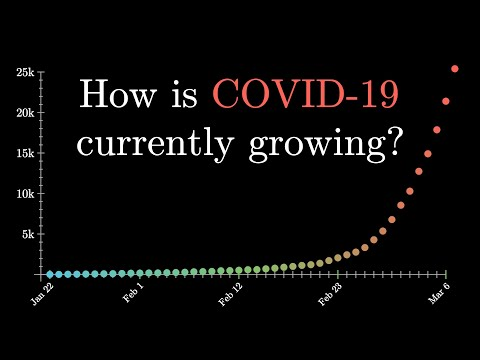

In [89]:
YouTubeVideo('Kas0tIxDvrg', width=400, height=300)

### Growth of cases of COVID-19



The number of new cases $\Delta N_d$ is proportional to the number of infected people $N_d$

$ \Delta N_d \approx N_d $

Where the constant relating these two is the product of

$E$ is average number of people someone infected is exposed to each day and 

$p$ is probability of each exposure becoming an infection.


$$
\Delta N_d = E p N_d
$$

The number of cases one day after $d$ is 

$$
\begin{align}
N_{d + 1} &= N_d + \Delta N_d \\
&= N_d + E p N_d \\
&= N_d (1 + E p)
\end{align}
$$

The number of cases two days later

$$
\begin{align}
N_{d + 2} & = N_{d + 1} + \Delta N_{d + 1} \\
 & = N_d (1 + E p) + E p N_{d + 1} \\
 & = N_d (1 + E p) + E p N_i (1 + E p) \\
 & = N_d (1 + E p) (1 + E p) \\
 & = N_d (1 + E p)^2
\end{align}
$$

So, the number of cases $n$ days later is

$$
N_{d + n} = N_d (1 + E p)^{d+n},
$$

Setting $d$ as the firt day of the pandemic, so $d=0$

$$
N_{n} = N_0 (1 + E p)^{n},
$$

where $N_0$ is the number of cases in day $0$. 
From the equatuion abouve we see that the number of cases $N_n$ grows exponentially with $(1 + E p)$ also called the growth factor $R$.

The growth factor tells us the fraction of new cases we'll get each day $\Delta N_{n}$ in comparison with the previous day $\Delta N_{n-1}$

$$
R =  \frac{\Delta N_{n}}{\Delta N_{n-1}} = (1 + E p).
$$

So, the number of cases $N_{n}$ on the $n$-th
$$
N_{n} = N_0 R^{n}.
$$



To keep things simple, this model is not correcting for recovering people, nor the effects of how the cases are reported. 

The number of new cases does not keep growing indefinitely; someone already infected cannot get infected again. We can correct this by subtracting the fraction of people who are already infected $\frac{N}{M}$, where $M$ is the total population. Thus, 
$$
\frac{dN}{dt} = c \bigg( 1 - \frac{N}{M} \bigg) N
$$
which has as solution a logistic curve.

[top](#Outline)

### <a name="Naive"></a> Naive calculation of the growth rate

In [110]:
time_series['R_changes'] = time_series['new_cases'].shift() / time_series['new_cases']

Plot the distribution of $R$ for the countries with the highest number of cases

(0, 2)

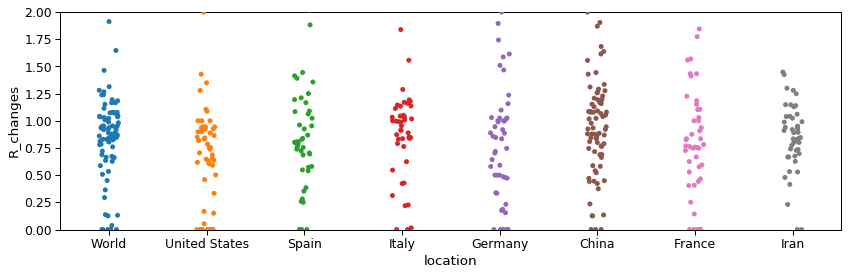

In [111]:
plt.figure(figsize=(14,4))
sns.stripplot(x='location', y='R_changes', data=time_series, order=sorted_cases_locs[:8])
plt.ylim(0,2)

Evolution of the value of $R$ for a country

In [92]:
x_loc = 'Mexico' #  Germany Italy Spain China World
df = time_series[time_series['location'] == x_loc]

fig = go.Figure([go.Scatter(x=df['date'], y=df['R_changes'], mode='markers')])

fig.show()

Distribution of the calculated $R$s

Text(0.5, 0, 'R')

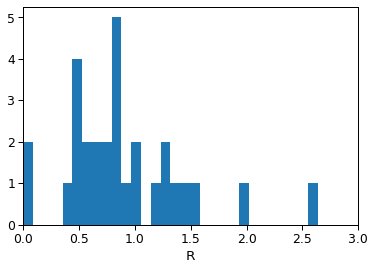

In [93]:
x = df['R_changes']
plt.hist(x[np.isfinite(df['R_changes'])], bins=30)
plt.xlim(0,3)
plt.xlabel('R')

Estimating $R$ as the ratio between the new cases in two consecutive days yields an enormuous rage of values. 
Now we'll estimate $R$ under the hypothesis of exponential growth.


[Top](#Outline)

### <a name = "R"></a> Estimate $R$ during the exponential growth face

We'll compute $R$ assuming exponential growth, fitting a model and from there determining $R$. 
But first, let's have a look at the number of cases as a function of time.

In [94]:
x_loc = 'Mexico'#'United States' #  Germany Italy Spain China World
df = time_series[time_series['location'] == x_loc]

fig = go.Figure([go.Scatter(x=df['date'], y=df['total_cases'], mode='markers')])

fig.show()

Identify a range of days where the $N$ is increasing exponentially

In [100]:
date0 = '2020-03-15' #'2020-01-21'
datef = df['date'].max()#'2020-03-27'

df_days = df[(df['date'] >= date0) & (df['date'] <= datef)]

fig = go.Figure([go.Scatter(x=df_days['date'], y=df_days['total_cases'], mode='markers')])
fig.show()

In the initial face of a pandemic, the number of cases grows exponentially over time

$$
N(n) = N_0 R^n
$$

Taking the logarithm of this equation we obtain a linear dependence on $n$

$$
\begin{align}
\log(N(n)) &= \log(N_0 R^n) \\
&= n \log(R) + \log(N_0),  \, \, \, \, \mbox{   defining $m=\log(R)$ and $b = \log(N_0)$} \\
&= m n + b.
\end{align}
$$

Therefore, we can estimate the growth rate as the exponenital of the slope of the line $R = e ^{m}$ 


y = 0.17 x + 4.13
r^2 = 0.9866
R = 1.2


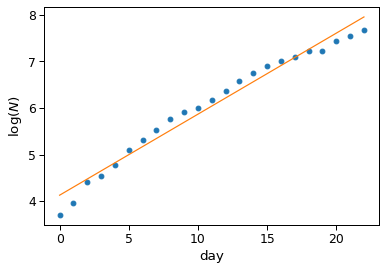

In [101]:
fig, ax = plt.subplots()

x0 = df_days['date']
x = np.arange(len(x0))  # convert dates to day number since start of the pandemia
y = np.log(df_days['total_cases'])
ax.plot(x, y, 'o')

m, b, cor_coeff, _, _ = stats.linregress(x, y)
lin = lambda x : m * x + b
ax.plot(x, lin(x))

ax.set_xlabel('day')
ax.set_ylabel('$\log(N)$')

R = np.exp(m)
print("y = {:.2f} x + {:.2f}\nr^2 = {:.4f}\nR = {:.1f}".format(m, b, cor_coeff, R))

In [102]:
N0 = df.loc[df['date'] == date0]['total_cases'].values[0]
print("N0", N0)
d = 65
future_day = (datetime.date.fromisoformat(date0) + pd.Timedelta(days=d))

print("With an infection rate R = {:.2f} in {} "\
      "the number of cases on {} is {:.2e}.".format(R, x_loc, 
                                                    future_day.strftime('%Y-%m-%d'), N0*R**d))

Rs = R - 0.05
print("With a slightly smaller infection rate R = {:.2f}, "\
      "the number of cases would be {:.2e}.".format(Rs, N0*(Rs)**d))

N0 41
With an infection rate R = 1.19 in Mexico the number of cases on 2020-05-19 is 3.30e+06.
With a slightly smaller infection rate R = 1.14, the number of cases would be 2.02e+05.


In [103]:
df_days.loc[:, 'predicted_cases_1'] = [N0*R**n for n in range(len(df_days))]
df_days.loc[:, 'predicted_cases_2'] = [N0*Rs**n for n in range(len(df_days))]

In [104]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_days['date'], y=df_days['total_cases'], mode='markers', 
                         name='total cases'))

fig.add_trace(go.Scatter(x=df_days['date'], y=df_days['predicted_cases_1'],
                         name='predicted cases R={:.2f}'.format(R)))


fig.add_trace(go.Scatter(x=df_days['date'], y=df_days['predicted_cases_2'],
                         name='predicted cases R={:.2f}'.format(Rs)))

fig.show()

### Effective reproduction number R

[2] ...

$R$ is the actual infection rate and is a measure of potential transmissibility [1].

* if $R > 1$ ==> the virus will continue to spread
* if $R < 1$ ==> the virus will peter out

$R$ depends on the infection rate $R_0$, which is the average number of people that one sick person can infect [1]. 

* $R_0$ is not easy to calculate because, especially at the beginning we don't know how many actual cases are there. 
* $R_0$ is not easy to interpret, because is a average number. We can have an $R_0$ of $2$ under two very different scenarios. One "super-spreader" infecting 100 people and 49 infecting people infecting none [2]. The first case is much better because while the super-spreder case is dangerous for health-care workers, most infected people won't infect others. The problematic cases may be detected more easily due to their dramatic nature according to David Fisman from the University of Toronto [2].

With measures like quarentine, social distancing and hand washing, $R$ can be reduced. 

Create datafram with the total cases, total deaths and case fatality rate (CFR) by country. 

[Top](#Outline)

## Flatten the curve

Citing [4]

"The message? If we take measures, we can temper the growth of the number of cases, which doesn’t necessarily mean that there will ultimately be fewer cases, just that there will be fewer cases at the same time. This is essential to ensure that the healthcare system is not overburdened. And, of course, let’s hope there is a way to reduce the total number of cases as well."

‘These Simulations Show How to Flatten the Coronavirus Growth Curve’. n.d. Washington Post. Accessed 22 March 2020. https://www.washingtonpost.com/graphics/2020/world/corona-simulator/.


<a href="https://useruploads.cdn-thecorrespondent.com/image/xVQXegW7MmCHgKxe4xniyA6Heng=/1920x1356/tc-useruploads-images/4eddc38df874430395c71c98648f0c59.jpg"><img width="512" src="https://useruploads.cdn-thecorrespondent.com/image/xVQXegW7MmCHgKxe4xniyA6Heng=/1920x1356/tc-useruploads-images/4eddc38df874430395c71c98648f0c59.jpg"></a>



[Top](#Outline)

# <a name="References"></a> References


<a name="r_data"></a>[5] ‘Coronavirus Source Data’. n.d. Our World in Data. Accessed 23 March 2020. https://ourworldindata.org/coronavirus-source-data.

<a name="r_corr"></a>[1] Blauw, Sanne. 2020. ‘Deciphering the Pandemic: A Guide to Understanding the Coronavirus Numbers’. The Correspondent. 17 March 2020. https://thecorrespondent.com/352/deciphering-the-pandemic-a-guide-to-understanding-the-coronavirus-numbers/46555890304-c23a82af.

<a name="r_Yong"></a>[2] Yong, Ed. 2020. ‘The Deceptively Simple Number Sparking Coronavirus Fears’. The Atlantic. 28 January 2020. https://www.theatlantic.com/science/archive/2020/01/how-fast-and-far-will-new-coronavirus-spread/605632/.

<a name="3blue1brown"></a>[3] ‘Exponential Growth and Epidemics’. n.d. 3Blue1Brown. Accessed 22 March 2020. https://www.3blue1brown.com/videos-blog/exponential-growth-and-epidemics.

<a name="r_Barklay"></a>[4] Barclay, Eliza. 2020. ‘How Canceled Events and Self-Quarantines Save Lives, in One Chart’. Vox. 10 March 2020. https://www.vox.com/2020/3/10/21171481/coronavirus-us-cases-quarantine-cancellation.


<a name="r_12Feb"></a>[6] ‘How to Interpret the 15,152 Surge in COVID-19 New Cases of February 12 - Worldometer’. n.d. Accessed 23 March 2020. https://www.worldometers.info/coronavirus/how-to-interpret-feb-12-case-surge/.

